In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


<Axes: >

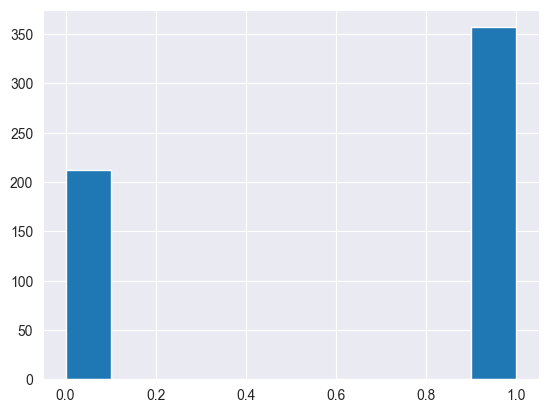

In [4]:
df['diagnosis'].hist()

<Axes: >

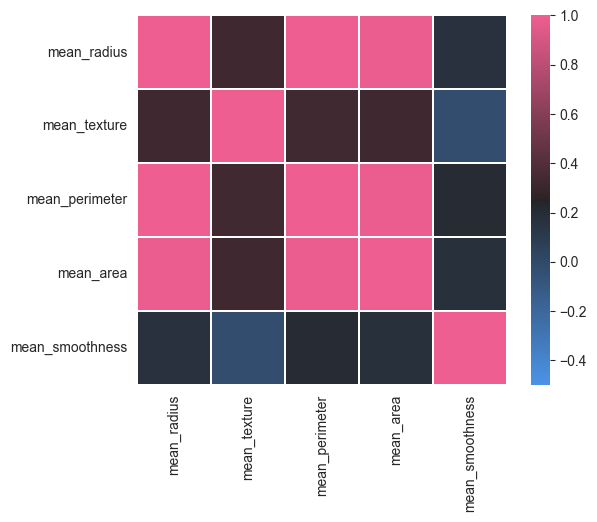

In [5]:
corr = df.iloc[:,:-1].corr(method='pearson')
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr,vmax = 1,vmin=-.5,cmap=cmap,square=True,linewidth=.2)

In [6]:
#for a naive bayes classifier, the data should be independent
df = df[['mean_radius','mean_texture','mean_smoothness','diagnosis']]
df.head()

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0


<Axes: xlabel='mean_texture', ylabel='Count'>

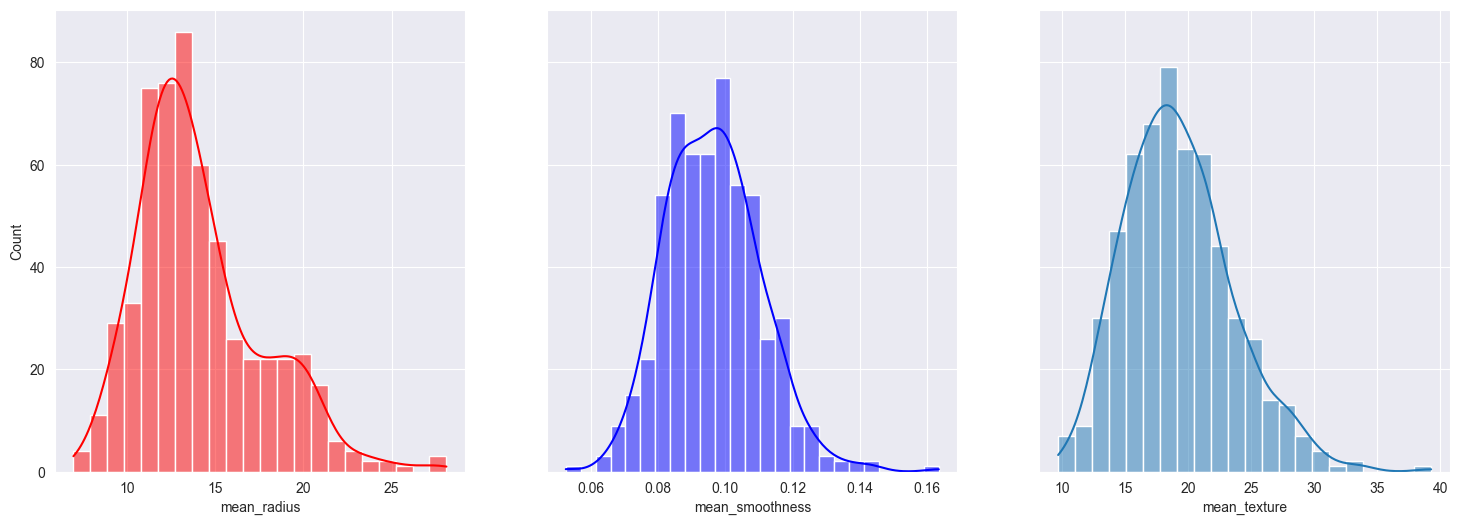

In [8]:
fig,axes = plt.subplots(1,3,figsize=(18,6),sharey=True)
sns.histplot(df,ax = axes[0],x = 'mean_radius',kde=True,color='r')
sns.histplot(df,ax = axes[1],x = 'mean_smoothness',kde=True,color='b')
sns.histplot(df,ax = axes[2],x = 'mean_texture',kde=True)

In [9]:
#mean_smoothness and mean_texture follow a normal distribution
def calculate_prior(df,y):
    classes = sorted(list(df[y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[y]==i])/len(df))
    return prior

In [10]:
def calculate_likelihood_gaussian(df,feat_name,feat_val,y,label):
    feat = list(df.columns)
    df  = df[df[y] == label]
    mean,std = df[feat_name].mean(),df[feat_name].std()
    p_x_given_y = (1/(np.sqrt(2*np.pi)*std))*np.exp(-((feat_val-mean)**2/(2*std**2)))
    return p_x_given_y

In [15]:
def naive_bayes_gaussian(df,x,y):
    features = list(df.columns)[:-1]
    prior = calculate_prior(df,y)
    y_pred = []
    for xs in x:
        labels = sorted(list(df[y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j]*=calculate_likelihood_gaussian(df,features[i],xs[i],y,labels[j])
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j]= likelihood[j]*prior[j]
        y_pred.append(np.argmax(post_prob))
    return np.array(y_pred)

In [18]:
from sklearn.model_selection import train_test_split
train,test =train_test_split(df,test_size=.2,random_state=41)
x_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values
y_pred = naive_bayes_gaussian(train,x = x_test,y = 'diagnosis')

from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,y_pred))
print(f1_score(y_test,y_pred))
f = np.array(confusion_matrix(y_test,y_pred))
print(f'The number of true positives is {f[0,0]}')
print(f'The number of false positives is {f[0,1]}')
print(f'The number of false negatives is {f[1,0]}')
print(f'The number of true negatives is {f[1,1]}')


[[36  4]
 [ 0 74]]
0.9736842105263158
The number of true positives is 36
The number of false positives is 4
The number of false negatives is 0
The number of true negatives is 74


In [19]:
#Convert continuous features into categorical features
df['cat_mean_radius'] = pd.cut(df['mean_radius'].values,bins = 3,labels=[0,1,2])
df['cat_mean_texture'] = pd.cut(df['mean_texture'].values,bins = 3,labels=[0,1,2])
df['cat_mean_smoothness'] = pd.cut(df['mean_smoothness'].values,bins = 3,labels=[0,1,2])

df = df.drop(columns=['mean_radius','mean_smoothness','mean_texture'])
df.head()

,diagnosis,cat_mean_radius,cat_mean_texture,cat_mean_smoothness
0,0,1,0,1
1,0,1,0,0
2,0,1,1,1
3,0,0,1,2
4,0,1,0,1


In [22]:
df.columns[1:]

Index(['cat_mean_radius', 'cat_mean_texture', 'cat_mean_smoothness'], dtype='object')

In [20]:
def calculate_likelihood_categorical(df,feat_name,feat_val,y,label):
    feat = list(df.columns)
    df = df[df[y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val])/len(df)
    return p_x_given_y

In [23]:
def naive_bayes_categorical(df,x,y):
    features = list(df.columns)[1:]
    prior = calculate_prior(df,y)
    y_pred = []
    for xs in x:
        labels = sorted(list(df[y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j]*=calculate_likelihood_categorical(df,features[i],xs[i],y,labels[j])
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j]= likelihood[j]*prior[j]
        y_pred.append(np.argmax(post_prob))
    return np.array(y_pred)

In [25]:
train,test =train_test_split(df,test_size=.2,random_state=41)
x_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].values
y_pred = naive_bayes_categorical(train,x = x_test,y = 'diagnosis')

from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,y_pred))
print(f1_score(y_test,y_pred))
f = np.array(confusion_matrix(y_test,y_pred))
print(f'The number of true positives is {f[0,0]}')
print(f'The number of false positives is {f[0,1]}')
print(f'The number of false negatives is {f[1,0]}')
print(f'The number of true negatives is {f[1,1]}')

[[38  2]
 [ 5 69]]
0.9517241379310345
The number of true positives is 38
The number of false positives is 2
The number of false negatives is 5
The number of true negatives is 69
